In [ ]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(pheatmap)
library(igraph)
library(ggraph)
library(tidygraph)


In [ ]:
# Read in GRN module
module <- read.table('module_summary.tsv',
                    sep='\t', header=TRUE)

# Clean up module
module$X <- NULL
module$context <- NULL

# Filter the module by weight
weight_filter <- 200
module <- module %>% filter(w > weight_filter)

# Pull out all morphogens involved
morphogens <- unique(module$morph)


In [ ]:
# Add regulon size into the module
# Extract TF name from module
TF <- gsub('\\(\\+\\)', '', module$gene)
TF <- unique(TF)

# Use grep() to identify morphogens starting with "M_" 
M_genes <- grep("^M_", TF, value = TRUE)
basal_media <- c('N2B27_SB_CHIR', 'N2B27_2Si', 'NIM')

# Print the identified genes starting with "M_"
print(M_genes)

# Remove M_genes from the gene list
TF <- setdiff(TF, M_genes)
TF <- setdiff(TF, basal_media)
print(TF)

# Create a dataframe for TF
# Read in corresponding regulon 
# Caultulate regulon size and add into dataframe

dir <- 'pyscenic/regulons/consensus_5'
tail <- '.txt'

regulon_size <- c()

for(i in seq_along(TF)){
    tmp <- read.table(paste0(dir, TF[i], tail), sep='\t')
    size <- length(unique(tmp$V1)) # Calculation of regulon size
    regulon_size <- c(regulon_size, size)
}

df <- data.frame(TF, regulon_size)

# Change the TF to TF(+)
df$TF <- paste0(df$TF, "(+)")


In [ ]:
# Generate a tbl_graph object with module
graph <- as_tbl_graph(module)

# Add regulon information as node attribute
nodes <- graph %>%
  activate(nodes) %>% as_tibble()

# Setting the names for morphogens and basal media (as special nodes)
morph_bm <- nodes$name[1:10]

# Create a dataframe for regulon size in morphogens
morph_regulon_size <- data.frame(morph_bm,
                                 20000)

# Change the name of morph_regulon_size to match with df
names(morph_regulon_size) <- c('TF', 'regulon_size')

# Comibing morph_regulon_size and df
regulon_size <- rbind(morph_regulon_size, df)


In [ ]:
# Add regulon_size and log_regulon_size to graph
graph <- graph %>% 
    activate(nodes) %>% 
    mutate(regulon_size = regulon_size$regulon_size) %>%
    mutate(log_regulon_size = log(regulon_size))


In [ ]:
# Read in regulon activiry per identity
auc_region <- readRDS('auc_region.rds')
auc_neuron_type <- readRDS('auc_neuron_type.rds')
auc_cl <- readRDS('auc_cl.rds')


In [ ]:
# Tidy the data to get $regulon $identity of max activity
df <- as.data.frame(auc_region)

# Extract the max value and corresponding column name for each row
max_values <- apply(df, 1, function(x) {
  max_value <- max(x)
  col_name <- names(x)[which.max(x)]
  c(Max_Value = max_value, Corresponding_Column = col_name)
})

max_activity <- t(max_values)
colnames(max_activity) <- c('Region_activity', 'Region')
max_activity <- max_activity[,c('Region', 'Region_activity')]

max_activity <- data.frame(rownames(max_activity), max_activity[,1:2])

names(max_activity) <- c('gene', 'Region', 'Region_act')

In [ ]:
# Add region and region activity to node attributes
graph = graph %>%
    activate(nodes) %>%
    left_join(max_activity, by = c("name" = 'gene'))

# Remove NA and fill in value for morphogens themselves
graph <- graph %>%
    activate(nodes) %>%
    mutate(Region = ifelse(is.na(Region), "NA", Region)) %>%
    mutate(Region_act = replace(Region_act, is.na(Region_act), 0.01))

In [ ]:
# Convert the 'Region_act' from character to numeric
# Access the node data using as_tibble()
node_data <- as_tibble(graph %>% activate(nodes))

# Convert the 'node_attribute' from character to numeric
node_data$Region_act <- as.numeric(node_data$Region_act)

# Update the node data in the tbl_graph object
graph <- graph %>%
  activate(nodes) %>%
  mutate(Region_act  = node_data$Region_act)


In [ ]:
# Include AUC value for each region for reach regulon
# Extract the column names and row names
column_names <- colnames(auc_region)
row_names <- rownames(auc_region)

# Scale the values of each row using apply()
scaled_data <- t(apply(auc_region, 1, scale))

# Convert the scaled data back to a data frame, add column names and row names
scaled_df <- as.data.frame(scaled_data)
colnames(scaled_df) <- column_names  
rownames(scaled_df) <- row_names
scaled_df$name <- rownames(scaled_df)

# Joining region regulon to the nodes
nodes <- left_join(nodes, scaled_df, by = 'name')


In [ ]:
# Replace NA from regulon activity (from cl_region) to 0.01
# Get the column indices to replace
col_indices <- c(2:8) 

# Use mutate_at to replace NA with 0.01 for the selected columns
nodes <- nodes %>%
  mutate_at(.vars = col_indices, .funs = ~ replace(., is.na(.), 0.01))


In [ ]:
# Joining new nodes to the nodes in graph
graph <- graph %>%
    activate(nodes) %>%
    left_join(nodes, by = c("name"))


In [ ]:
# Making layouts for the graph: fr
layout1 <- create_layout(graph, layout = 'fr')


In [ ]:
# Setting region order and corresponding color for plotting
region_order <- c('Forebrain', 'Midbrain', 'Hindbrain', 'Spinal cord', 
             'SYM', 'Optic cup', 'Other')

region_color <- c('#fe9b00', '#f4c40f', '#d8443c', '#9b3441',
               '#268a8a', '#633372', '#cccccc')


Warning message:
"Ignoring `graph` as layout is already calculated
i Pass the calculated layout to the `graph` argument to silence this warning"
Warning message:
"ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


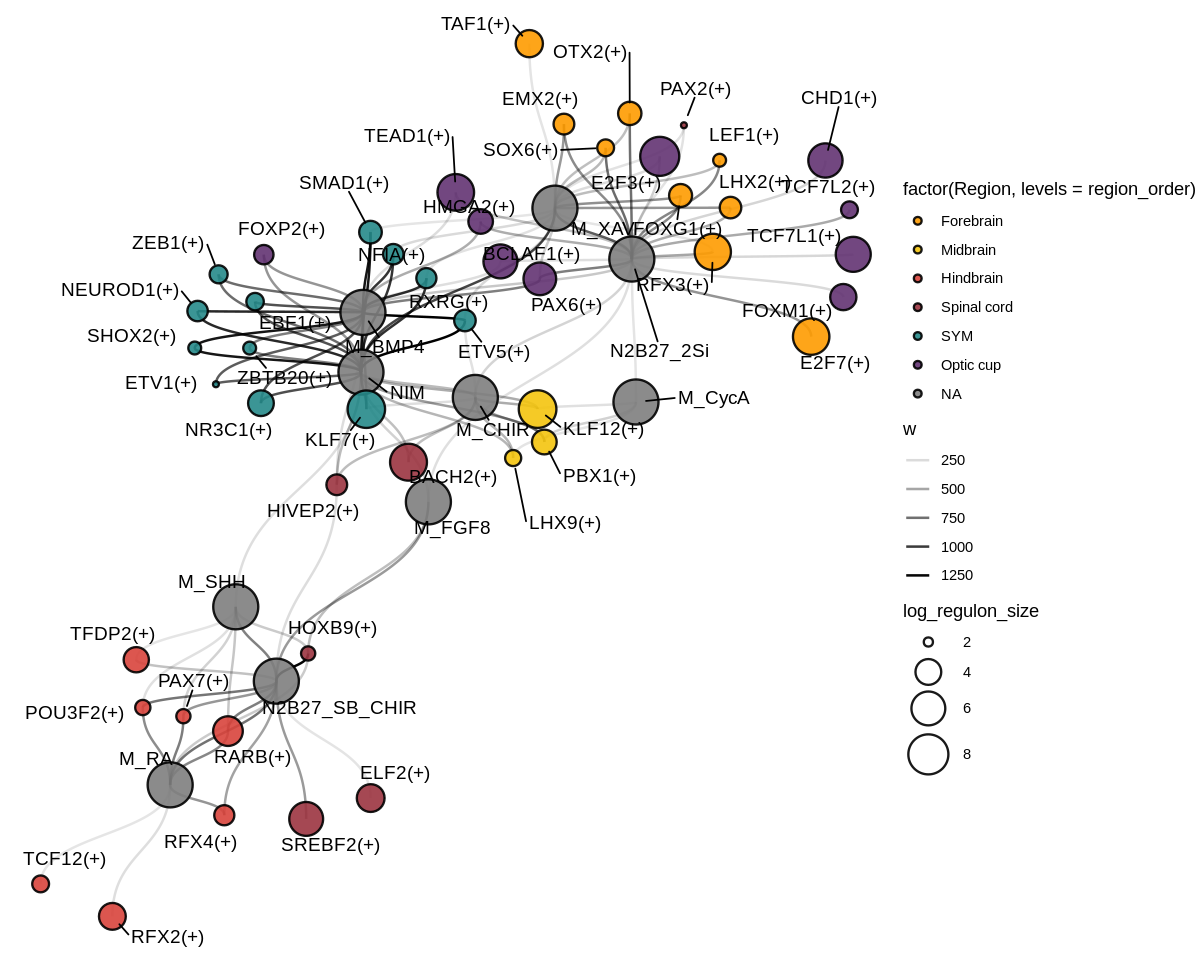

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
ggraph(graph, layout=layout1) + 
  geom_edge_diagonal (aes (edge_alpha = w), check_overlap = TRUE, edge_width=0.7) +
  geom_node_point(aes(size= log_regulon_size, 
                      fill = factor(Region, levels = region_order)),
                      shape = 21,
                      colour = 'black',
                      stroke = 1,
                  alpha = 0.9) +
  scale_size(range = c(1, 12)) +
  geom_node_text (aes (label = name), repel=TRUE, 
                  box.padding = 0.7, point.padding = 0.7,
                  size=4) +
  scale_fill_manual(values = region_color) +
  theme_void ()


Warning message:
"Ignoring `graph` as layout is already calculated
i Pass the calculated layout to the `graph` argument to silence this warning"


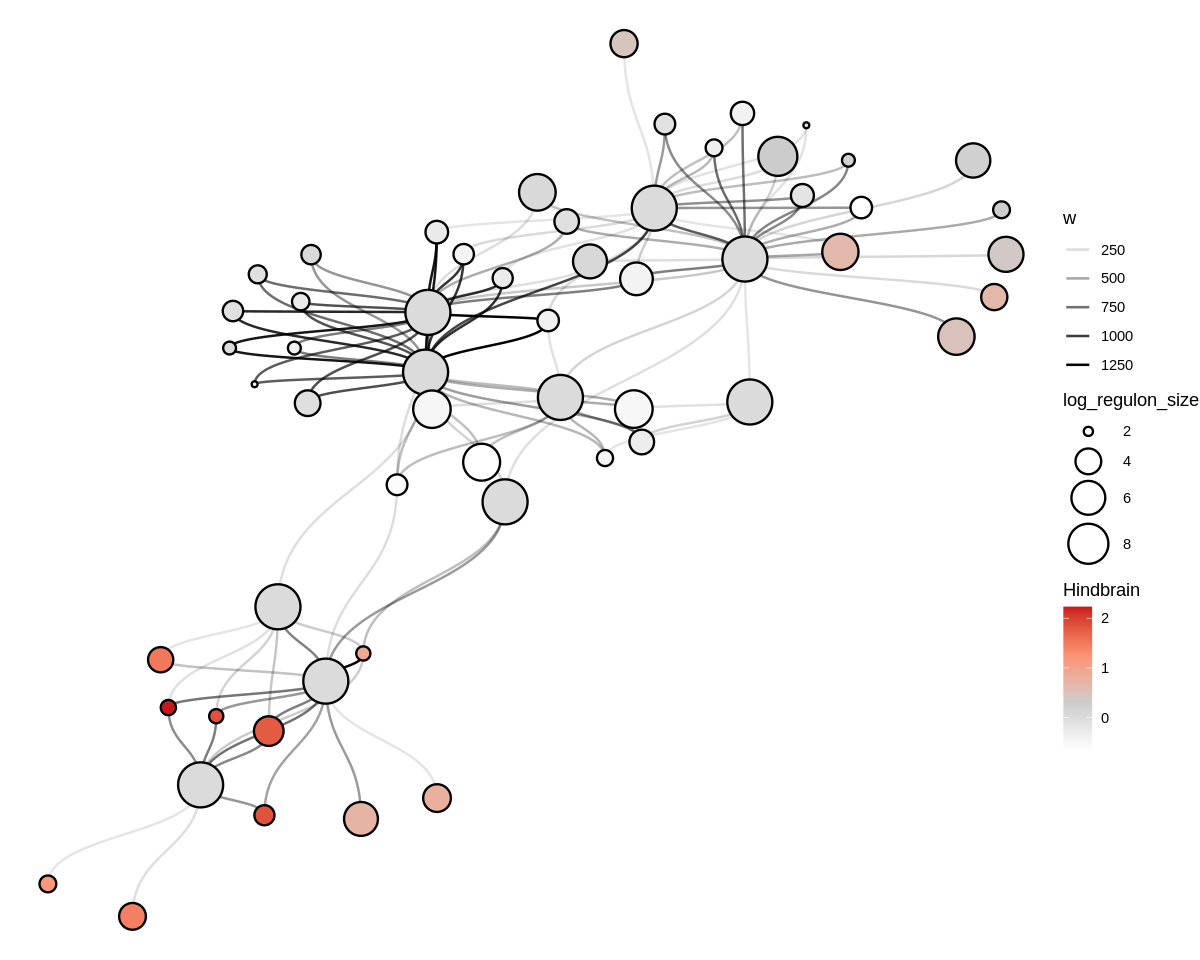

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
ggraph(graph, layout=layout1) + 
  geom_edge_diagonal (aes (edge_alpha = w), check_overlap = TRUE, edge_width=0.7) +
  geom_node_point(aes(size= log_regulon_size, fill=Hindbrain),
                  shape=21,
                  colour='black',
                  stroke=1,
                 ) +
  scale_size(range = c(1, 12)) +
  #geom_node_text (aes (label = name), repel=TRUE, 
  #                box.padding = 0.7, point.padding = 0.7,
  #                size=4) +
  #scale_colour_gradient(low = "white", high = "red") +
  scale_fill_gradientn(colours = c("white", "grey80", "#FC9272", "#CB181D")) +
  theme_void () 


Warning message:
"Ignoring `graph` as layout is already calculated
i Pass the calculated layout to the `graph` argument to silence this warning"


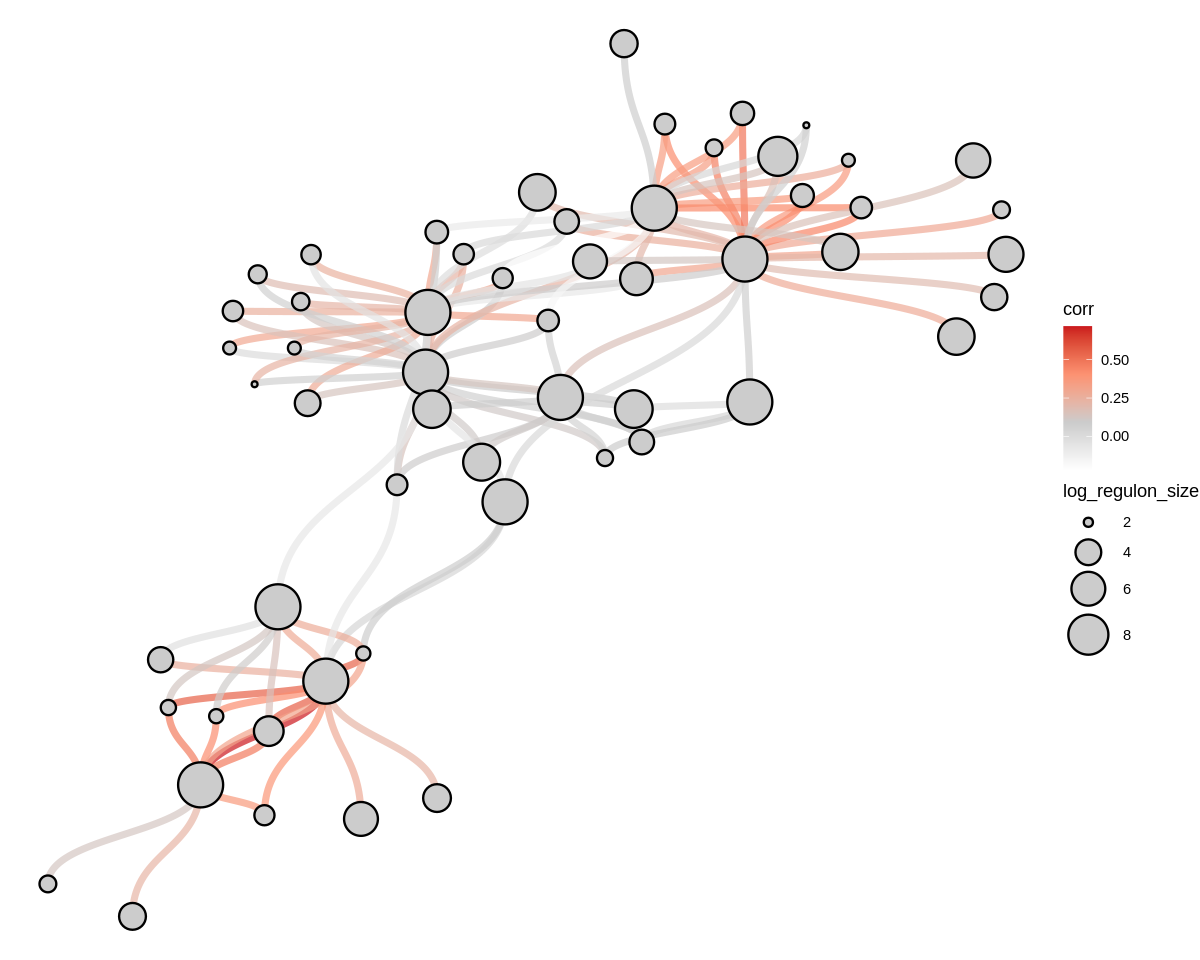

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
ggraph(graph, layout=layout1) + 
  geom_edge_diagonal (aes (edge_color = corr),
                      check_overlap = TRUE, edge_width=2,
                     edge_alpha = 0.7) +
  geom_node_point(aes(size= log_regulon_size), 
                  fill='#cccccc',
                  colour='black',
                  shape=21,
                  stroke=1
                 ) +
  scale_size(range = c(1, 12)) +
  scale_edge_color_gradientn(colours = c("white", "grey80", "#FC9272", "#CB181D")) +
  theme_void ()
